In [1]:
# The following is necessary to run the cells that follow. Run this cell once at the beginning, then not again.
%load_ext autoreload
# Changes made to .py files are reflected here
%autoreload 2       
# Reload all modules every time before executing the Python code typed.
%matplotlib inline 
# Allows for creation of the plots 
import sys         # used for path appending
import matplotlib.pyplot as plt # used for plotting
sys.path.append("../../") # / directory
sys.path.append("../")  # /src/ directory
plt.rcParams["figure.figsize"] = [6, 3.5] #  Size of figures created from plots by default [12,7]

# A gc_event_dataframe has the following columns
> ## DateTime

> ## TimeFromStart_seconds

> ## EventType

> ## EventName

> ## AdditionalEventInfo

> ## MemoryChange_MB

> ## Duration_miliseconds

In [2]:
                        # Fill in the following 3 variables
################################################################################################
files = ["/Users/ellisbrown/Desktop/ngs3/solr-out.log.2"]
labels = ["Shenandoah"]
# time_range_seconds = [0, 100]
time_range_seconds = None  # includes full log
################################################################################################
from src.read_log_file import get_parsed_comparions_from_files 

# Create a list data structure, with each item in the list being a gc_event_dataframe.
gc_event_dataframes = get_parsed_comparions_from_files(files, time_range_seconds,  ignore_crashes=True)

# This cell ^ needs to be re=run every time the files are changed.

## Compare STW pauses during runtime

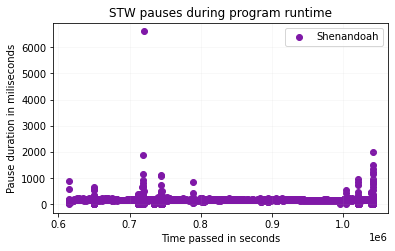

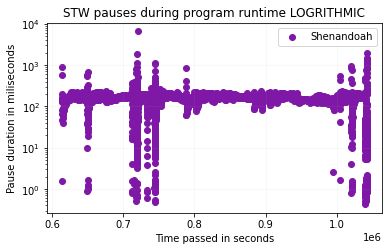

In [3]:
from plotting import plot_scatter

# Chart #1, linear Y axis

# Create a filter that will only take rows from a gc_event_dataframe that represent Pauses.
pauses_only = [(lambda row : row["EventType"] == "Pause")]

# Apply the filter, and create a plot
plot = plot_scatter(gc_event_dataframes,filter_by = pauses_only, labels=labels)

# Set the style and details on the plot
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
# The alpha value makes the grid harder to see.9
plot.grid(alpha = 0.1)

############################################################################################################

# Chart #2, logarithmic Y axis
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels)
plot.set_yscale("log") # LOGRITHMIC log set, using already plotted values
_ = plot.set_title("STW pauses during program runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)



## Concurrent durations during runtime

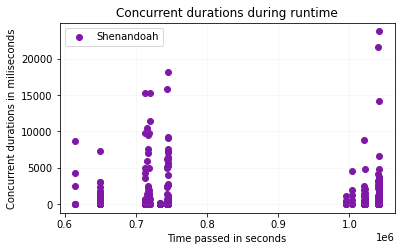

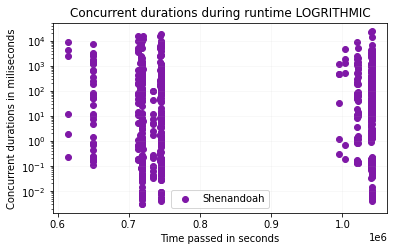

In [4]:
from plotting import plot_scatter

# Linear graph
concurrent_only = [(lambda row: row["EventType"] == "Concurrent")]
plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
_ = plot.set_title("Concurrent durations during runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Concurrent durations in miliseconds")
plot.grid(alpha = 0.1)

# Logarithmic graph
plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
plot.set_yscale("log")
_ = plot.set_title("Concurrent durations during runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Concurrent durations in miliseconds")
plot.grid(alpha = 0.1)


## Time spent in STW vs. Concurrent

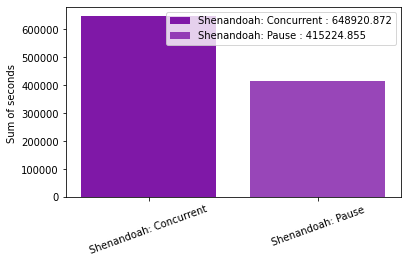

In [5]:
from plotting import plot_bar_sum



duration_present = [(lambda row: row["Duration_miliseconds"] != None)]
# The grouping by eventtype means that every matching event name lives in one group. 
# Example: "Concurrent" events are a group, and "Pause" events are a group
graph = plot_bar_sum(gc_event_dataframes, group_by = "EventType", filter_by = duration_present, labels= labels)
_ = graph.set_title = "Sum of event durations in miliseconds"
_ = graph.set_ylabel("Sum of seconds ")
_ = plt.xticks(rotation = 20)



## Comparing Trends within the data

In [6]:
from plotting import plot_trends

print("\t\t\tPauses during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       filter_by = [lambda row: row["EventType"] == "Pause"],
       labels= labels,
       throughput=True)
print("\n")

print("\t\t\tPauses by name during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       group_by = "EventName",
       filter_by= [lambda row: row["EventType"] == "Pause"],
       labels= labels)


			Pauses during runtime
------------------------------------------------------------------------------------------------------------------
Legend: 
A | Shenandoah
-------------------------------------------------------------------------------------------------
  Trends (ms)   | Event Count   | Max Duration  | Sum Duration  | Mean Duration | Std Dev.      | Throughput    |
-----------------------------------------------------------------------------------------------------------------
A               | 2783.0000     | 6610.7820     | 415224.8550     |  149.2005     |  170.1985     |   99.9600     % 


			Pauses by name during runtime
------------------------------------------------------------------------------------------------------------------
Legend: 
A | Shenandoah: Cleanup
B | Shenandoah: Full
C | Shenandoah: Remark
D | Shenandoah: Young
-------------------------------------------------------------------------------------------------
  Trends (ms)   | Event Count   | Max Duration

## Percentiles of event durations

In [7]:
from plotting import plot_percentiles
print("\t\t\tPauses during runtime\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       filter_by = [lambda row: row["EventType"] == "Pause"],
       labels= labels)

print("\n\n")

print("\t\t\tPauses during runtime by name\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       group_by = "EventName",
       filter_by= [lambda row: row["EventType"] == "Pause"],
       labels= labels)

			Pauses during runtime
----------------------------------------------------------------------------------
Legend (All timing in miliseconds) : 
A | Shenandoah
-------------------------------------------------------------------------------------------------
    | 50%       | 75%       | 90%       | 95%       | 99%       | 99.9%     | 99.99%    | 
------------------------------------------------------------------------------------------------
A   |  158.3800 |  184.6760 |  211.3584 |  235.9142 |  562.5843 | 1597.6474 | 5327.9442 | 



			Pauses during runtime by name
----------------------------------------------------------------------------------
Legend (All timing in miliseconds) : 
A | Shenandoah: Cleanup
B | Shenandoah: Full
C | Shenandoah: Remark
D | Shenandoah: Young
-------------------------------------------------------------------------------------------------
    | 50%       | 75%       | 90%       | 95%       | 99%       | 99.9%     | 99.99%    | 
--------------------------

## Mean durations in miliseconds, pauses

['Shenandoah']
['Shenandoah']


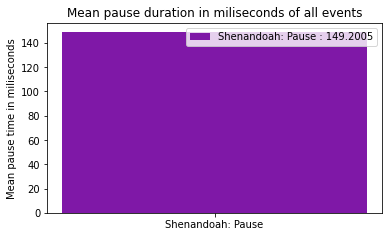

In [8]:

from plotting import plot_bar_avg
print(labels)
graph = plot_bar_avg(gc_event_dataframes, group_by = "EventType", filter_by = [lambda row: row["EventType"] == "Pause"], labels = labels)
_ = graph.set_title("Mean pause duration in miliseconds of all events")
_ = graph.set_ylabel("Mean pause time in miliseconds")
print(labels)

## Heap allocation used before & after GC

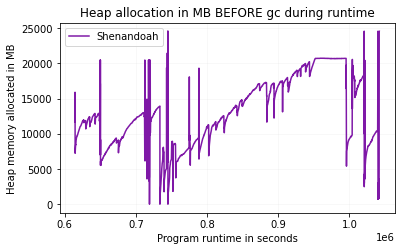

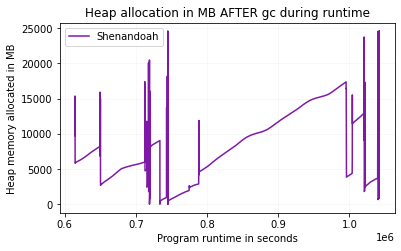

In [9]:
from plotting import plot_line


plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = [lambda row: row["HeapBeforeGC"] != None], # Confirm that this column has data for every row
            labels = labels,
            column = "HeapBeforeGC")

_ = plot.set_title("Heap allocation in MB BEFORE gc during runtime")
_ = plot.set_ylabel("Heap memory allocated in MB")
_ = plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = [lambda row: row["HeapAfterGC"]!= None],
            labels = labels,
            column = "HeapAfterGC")

_ = plot.set_title("Heap allocation in MB AFTER gc during runtime")
_ = plot.set_ylabel("Heap memory allocated in MB")
_ = plot.set_xlabel("Program runtime in seconds")

handles, labels = plot.get_legend_handles_labels()
plot.grid(alpha = 0.1)

## MB reclaimed during GC during runtime

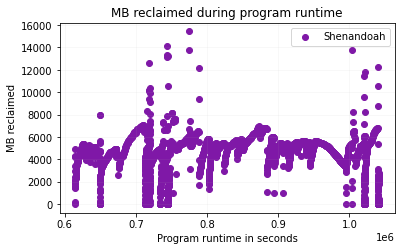

In [10]:
from plotting import plot_reclaimed_bytes

gc_values_present = [lambda row: row["HeapBeforeGC"] != None and row["HeapAfterGC"] != None]

plot = plot_reclaimed_bytes(gc_event_dataframes, filter_by = gc_values_present, labels = labels)
_ = plot.set_title("MB reclaimed during program runtime")
_ = plot.set_ylabel("MB reclaimed")
_ = plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

## Heatmaps for each log

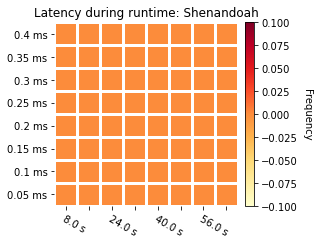

In [11]:
from src.graphing.heatmap import plot_heatmap, get_heatmap_data
for label, gc_event_dataframe in zip(labels, gc_event_dataframes):
    heatmap, dimensions = get_heatmap_data(gc_event_dataframe, 8,8,8,0.05, True)     # Set the last value to FALSE to get warnings                                                                              # Set true to false 
#plot_heatmap(heatmap, dimensions, True)
    graph = plot_heatmap(heatmap, dimensions, False) # Set the last value to TRUE to see labels of frequency
    graph.set_title("Latency during runtime: " +  label)
plt.rcParams["figure.figsize"] = [12, 7]


## Frequency of pauses histogram

['Shenandoah']


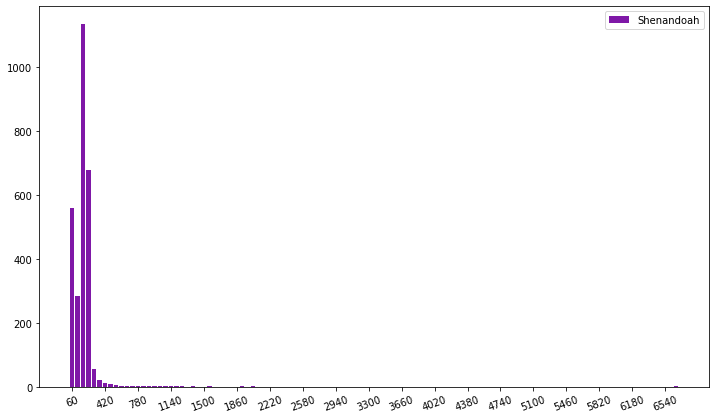

In [14]:
from plotting2 import plot_frequency_intervals

# All intervals are in seconds
print(labels)
plot = plot_frequency_intervals(gc_event_dataframes,
                         filter_by = [(lambda row: row["EventType"] == "Pause")], 
                         interval_duration= 60, 
                         labels = labels)
_ = plt.xticks(rotation = 20)


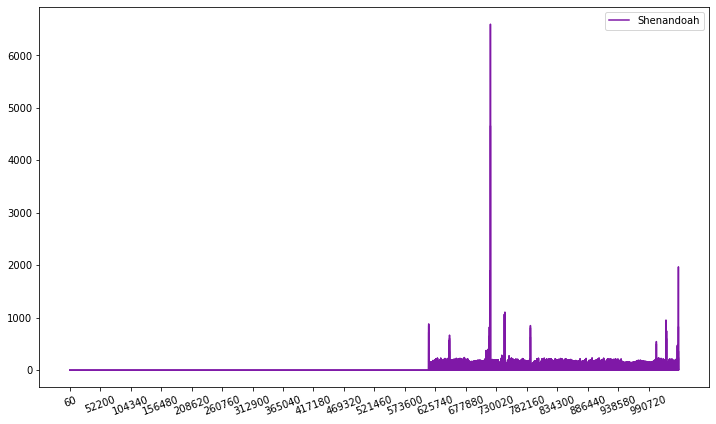

In [16]:
from plotting2 import plot_percentile_intervals

plot = plot_percentile_intervals(gc_event_dataframes, 
                                filter_by = [(lambda row: row["EventType"] == "Pause")], 
                                interval_duration = 60 ,
                                labels = labels,
                                percentiles = [99.9, 90, 50])
# plot = plot_percentile_intervals(gc_event_dataframes, 
#                                 filter_by = [(lambda row: row["EventType"] == "Pause")], 
#                                 interval_duration = 60 ,
#                                 labels = labels,
#                                 percentiles = [99.9, 90, 50])
# plot.set_ylabel("Pause duration in miliseconds")
# plot.set_xlabel("“Elapsed time in seconds")
# plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)

HERe!


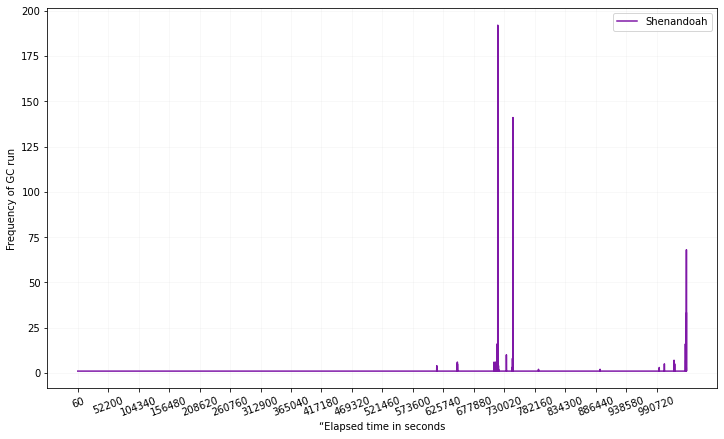

In [22]:
from plotting2 import plot_frequency_of_gc_intervals

plot = plot_frequency_of_gc_intervals(gc_event_dataframes, 
                                      filter_by = [(lambda row: row["EventType"] == "Pause")], 
                                      interval_duration = 60 , 
                                      labels = labels)
plot.set_ylabel("Frequency of GC run")
plot.set_xlabel("“Elapsed time in seconds")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)

0       161.248
1       880.406
2       561.232
7       156.117
9         1.526
         ...   
3804     11.815
3807     10.919
3808    306.639
3809    213.049
3811      9.339
Name: Duration_miliseconds, Length: 2783, dtype: object


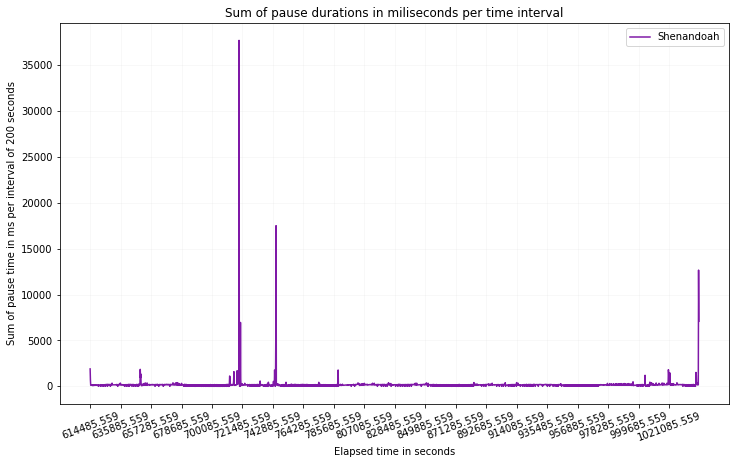

In [28]:
from plotting2 import plot_sum_pause_intervals


interval_duration = 1000
plot = plot_sum_pause_intervals(gc_event_dataframes,
                                filter_by = [(lambda row: row["EventType"] == "Pause")],
                                interval_duration = interval_duration, 
                                labels = labels)
_ = plot.set_title("Sum of pause durations in miliseconds per time interval")
plot.set_ylabel("Sum of pause time in ms per interval of " + str(interval_duration) + " seconds", )
plot.set_xlabel("Elapsed time in seconds")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)

In [ ]:
gc_event_dataframes[0]

,DateTime,TimeFromStart_seconds,EventType,EventName,AdditionalEventInfo,HeapBeforeGC,HeapAfterGC,Duration_miliseconds
0,None,614285.559,Pause,Young,(Normal) (G1 Evacuation Pause),11724.0,9756.0,161.248
1,None,614449.925,Pause,Young,(Normal) (G1 Evacuation Pause),15900.0,13456.0,880.406
2,None,614459.924,Pause,Young,(Concurrent Start) (G1 Humongous Allocation),15542.0,15363.0,561.232
3,None,614459.924,Concurrent,Clear Claimed Marks,,None,None,0.237
4,None,614459.936,Concurrent,Scan Root Regions,,None,None,12.235
...,...,...,...,...,...,...,...,...
3807,None,1041980.118,Pause,Young,(Normal) (G1 Humongous Allocation),24572.0,24572.0,10.919
3808,None,1041980.425,Pause,Full,(G1 Humongous Allocation),24572.0,24572.0,306.639
3809,None,1041980.639,Pause,Full,(G1 Humongous Allocation),24572.0,24572.0,213.049
3810,None,1041980.64,Concurrent,Mark From Roots,,None,None,550.86
